In [19]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dqn.config import Config

In [20]:
def load_data(folder='results'):
    data = {}
    test_types = os.listdir(folder)
    for test_type in test_types:
        path = f'{folder}/{test_type}/deals_history.pkl'
        with open(path, 'rb') as f:
            result = processing_data(pickle.load(f))
            data[test_type] = result
    return data


def processing_data(data):
    data = (pd.DataFrame(data)
        .dropna()
        .assign(balance_profit = lambda _df: 100 * (_df.close_balance-_df.entry_balance) / _df.close_balance)
        .assign(profit = lambda _df: 100 * (_df.close_price-_df.entry_price) / _df.close_price)
    )
    return data

In [21]:
data = load_data()
test_types = list(data)
test_types.sort()

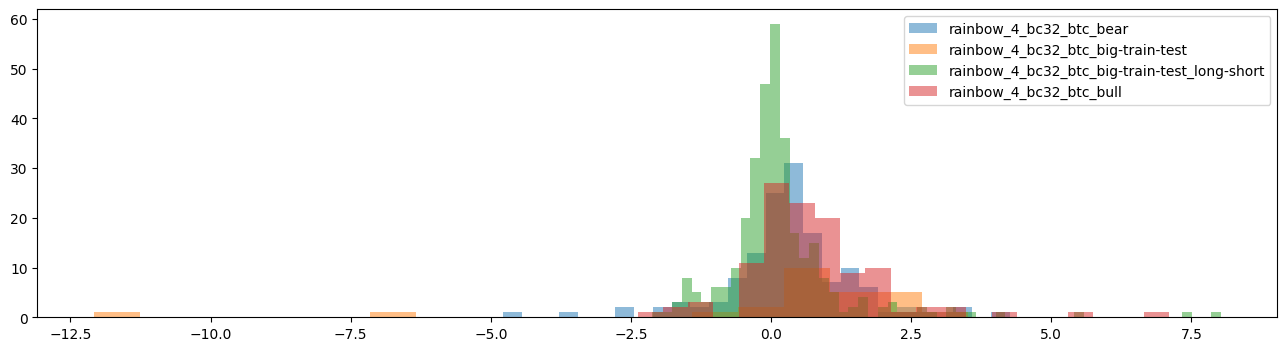

In [22]:
using_results = ['rainbow_4_bc32_btc_bear', 'rainbow_4_bc32_btc_bull', 'rainbow_4_bc32_btc_big-train-test', 'rainbow_4_bc32_btc_big-train-test_long-short']
plt.figure(figsize=(16,4))
for test_type in test_types:
    if test_type not in using_results:
        continue
    plt.hist(data[test_type].profit, bins='auto', label=test_type, alpha=0.5)
plt.legend()

In [23]:
for test_type in using_results:
    print(f'{test_type} avg profit: {data[test_type].profit.mean():.3f}')

rainbow_4_bc32_btc_bear avg profit: 0.329
rainbow_4_bc32_btc_bull avg profit: 0.756
rainbow_4_bc32_btc_big-train-test avg profit: 0.356
rainbow_4_bc32_btc_big-train-test_long-short avg profit: 0.169


In [24]:
for test_type in using_results:
    print(f'{test_type} median profit: {data[test_type].profit.median():.3f}')

rainbow_4_bc32_btc_bear median profit: 0.314
rainbow_4_bc32_btc_bull median profit: 0.560
rainbow_4_bc32_btc_big-train-test median profit: 0.895
rainbow_4_bc32_btc_big-train-test_long-short median profit: 0.050


In [25]:
for test_type in using_results:
    print(f'{test_type} median balance profit: {data[test_type].balance_profit.mean():.3f}')

rainbow_4_bc32_btc_bear median balance profit: -0.070
rainbow_4_bc32_btc_bull median balance profit: 0.355
rainbow_4_bc32_btc_big-train-test median balance profit: -0.031
rainbow_4_bc32_btc_big-train-test_long-short median balance profit: -0.130


In [26]:
clip_value = 0.5
for test_type in using_results:
    print(f'Clip [-{clip_value}, {clip_value}] {test_type} avg profit: {data[test_type].profit.mean():.3f}')

# print(f'Clip [-{clip_value}, {clip_value}] Base avg profit: {base_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Double avg profit: {double_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Dueling avg profit: {dueling_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Rainbow2 avg profit: {rainbow2_results.profit.clip(-clip_value,clip_value).mean():.3f}')

Clip [-0.5, 0.5] rainbow_4_bc32_btc_bear avg profit: 0.329
Clip [-0.5, 0.5] rainbow_4_bc32_btc_bull avg profit: 0.756
Clip [-0.5, 0.5] rainbow_4_bc32_btc_big-train-test avg profit: 0.356
Clip [-0.5, 0.5] rainbow_4_bc32_btc_big-train-test_long-short avg profit: 0.169


In [27]:
for test_type in using_results:
    print(f'{test_type} std profit: {data[test_type].profit.std():.3f}')

rainbow_4_bc32_btc_bear std profit: 1.181
rainbow_4_bc32_btc_bull std profit: 1.251
rainbow_4_bc32_btc_big-train-test std profit: 3.102
rainbow_4_bc32_btc_big-train-test_long-short std profit: 1.085


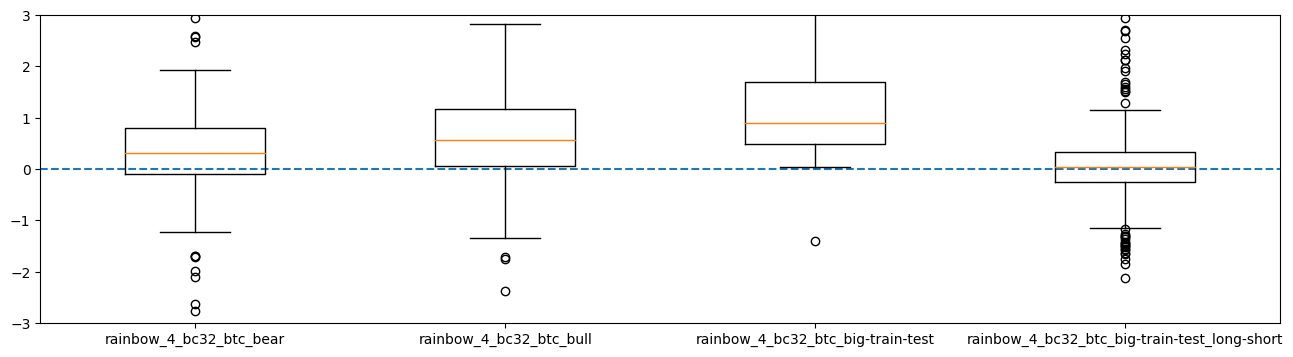

In [28]:
plt.figure(figsize=(16,4))
plt.axhline(0, linestyle='--')
plt.boxplot([data[test_type].profit.values for test_type in using_results], labels=using_results)
plt.ylim(-3,3)
# plt.legend()
print()

In [29]:
for test_type in using_results:
    coef = np.corrcoef(data[test_type].profit, data[test_type].predict_q)
    print(f'{test_type} corr coef with profit and Q value: {coef[0, 1]:.3f}')

rainbow_4_bc32_btc_bear corr coef with profit and Q value: -0.002
rainbow_4_bc32_btc_bull corr coef with profit and Q value: 0.089
rainbow_4_bc32_btc_big-train-test corr coef with profit and Q value: 0.032
rainbow_4_bc32_btc_big-train-test_long-short corr coef with profit and Q value: 0.024


In [30]:
using_results

['rainbow_4_bc32_btc_bear',
 'rainbow_4_bc32_btc_bull',
 'rainbow_4_bc32_btc_big-train-test',
 'rainbow_4_bc32_btc_big-train-test_long-short']

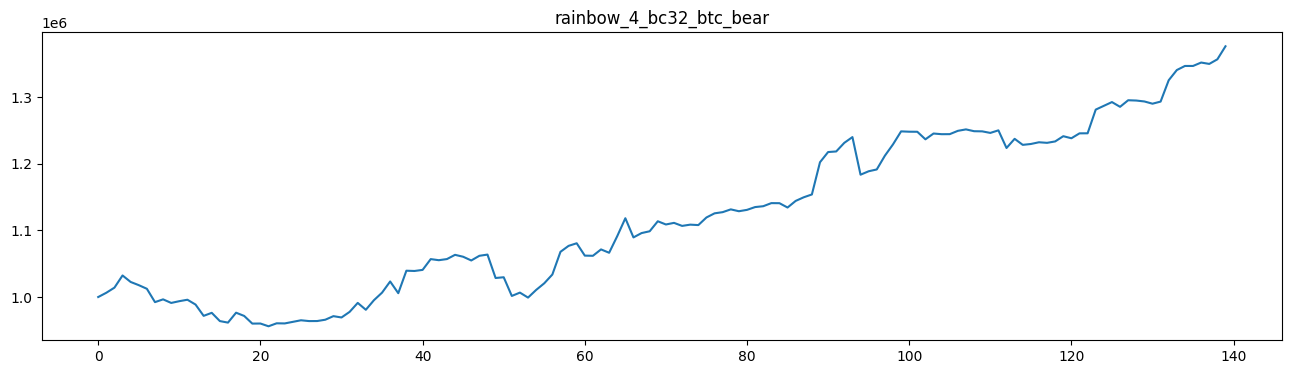

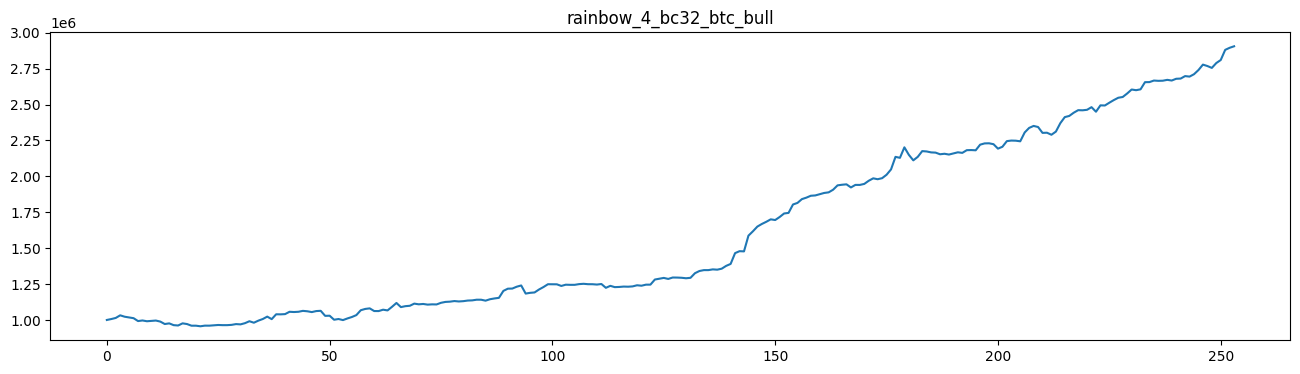

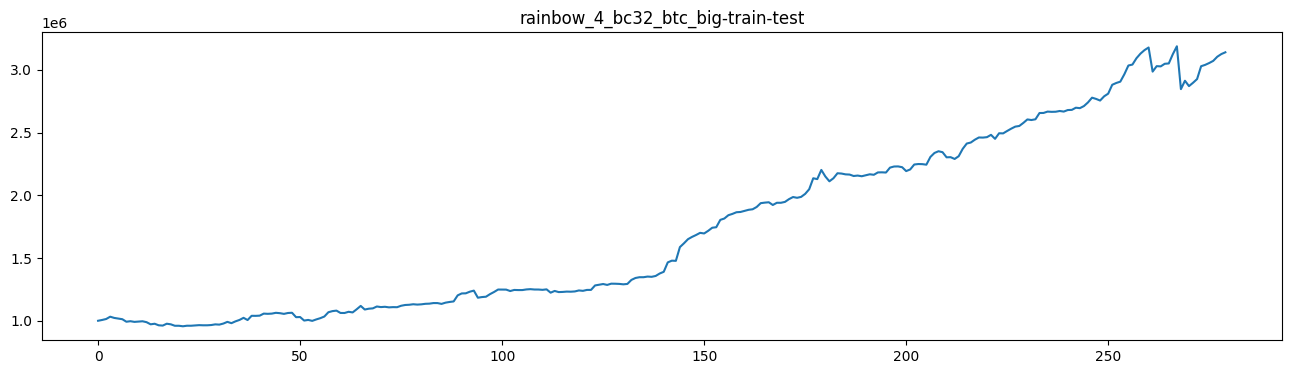

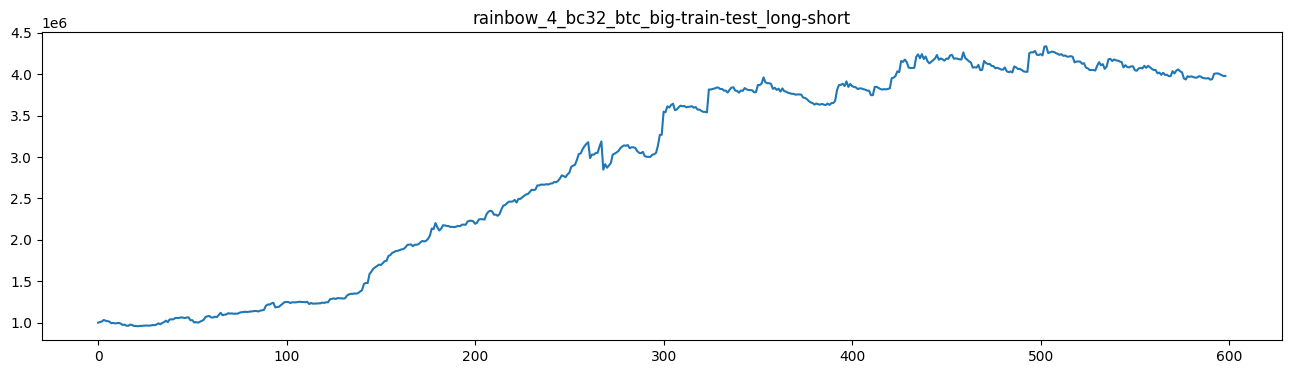

In [33]:
balance_arr = [1_000_000]
comis = 0.0005

for test_type in using_results:
    data[test_type] = data[test_type].reset_index(drop=True)
    for i in range(data[test_type].shape[0]):
        ep, cp = data[test_type].at[i, 'entry_price'], data[test_type].at[i, 'close_price']
        last_balance = balance_arr[-1]
        buy_c = last_balance // ep - 1
        last_balance -= buy_c * ep * (1 + comis)
        last_balance += buy_c * cp * (1 - comis)
        balance_arr.append(last_balance)
    
    plt.figure(figsize=(16,4))
    plt.title(test_type)
    plt.plot(balance_arr)

In [19]:
def dots_to_line(_df, dot_idx: np.array, line_col: str):
    _df[line_col] = np.nan
    _df.loc[dot_idx, line_col] = _df.loc[dot_idx, 'close']
    return _df

config = Config() 
test_type = 'rainbow_4_bc32_btc_big-train-test'
deals_df = data[test_type]
price_df = pd.read_csv(config.data_path).iloc[-10000:].reset_index(drop=True)

price_df = (price_df
    .pipe(lambda _df: dots_to_line(_df, dot_idx=deals_df.entry_step_i.values, line_col='entry_dots'))
    .pipe(lambda _df: dots_to_line(_df, dot_idx=deals_df.close_step_i.values, line_col='close_dots'))    
)

In [14]:
# st, ed = 0, 2000
# plt.figure(figsize=(16,4))
# plt.plot(price_df.loc[st:ed, 'close'])
# plt.plot(price_df.loc[st:ed, 'entry_dots'], marker='^', color='g')
# plt.plot(price_df.loc[st:ed, 'close_dots'], marker='v', color='r')

In [34]:
deals_result = data['rainbow_4_bc32_btc_big-train-test_long-short']

In [39]:
deals_result.groupby('position_type', as_index=False).profit.mean()

,position_type,profit
0,long,0.246622
1,short,0.091159


In [40]:
deals_result

,entry_step_i,entry_price,entry_balance,predict_q,position_type,close_step_i,close_price,close_balance,balance_profit,profit
0,32,17774.70,1.000000e+06,0.124300,short,53,17765.97,9.986425e+05,-0.135937,-0.049139
1,53,17765.97,9.986425e+05,0.714706,long,54,17832.65,1.000215e+06,0.157207,0.373921
2,54,17832.65,1.000215e+06,0.953012,short,58,17631.60,1.008574e+06,0.828772,-1.140282
3,58,17631.60,1.008574e+06,1.072565,long,59,17716.77,1.011139e+06,0.253668,0.480731
4,59,17716.77,1.011139e+06,0.669964,short,60,17729.56,1.008661e+06,-0.245639,0.072139
...,...,...,...,...,...,...,...,...,...,...
314,4882,31120.69,6.818890e+05,0.509309,short,4883,31156.20,6.799606e+05,-0.283598,0.113974
315,4883,31156.20,6.799606e+05,0.409986,long,4884,31112.86,6.778863e+05,-0.306003,-0.139299
316,4884,31112.86,6.778863e+05,0.377173,short,4888,31058.00,6.777429e+05,-0.021153,-0.176637
317,4888,31058.00,6.777429e+05,0.275164,long,4890,30999.55,6.753762e+05,-0.350431,-0.188551
